In [1]:
%pip install Levenshtein
%pip install transformers
%pip install accelerate
%pip install diffusers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.1 MB/s eta 0:00:00


In [2]:
# IMPORTS

import psutil
import json
import os
import random
import time
import torch
import uuid

from datetime import datetime
from Levenshtein import distance
from jinja2 import Template
from PIL import Image


import os
import re
import torch
from IPython.display import display
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
from diffusers import AutoencoderKL


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# VARIOUS HELPER FUNCTIONS

### SIMILARITY CALCULATIONS FOR TRACK NAMES

SIMILARITY_DISTANCE = 3
def are_tracks_similar(tracks):
    for i in range(len(tracks)):
        for j in range(i + 1, len(tracks)):
            if distance(tracks[i]['name'], tracks[j]['name']) < SIMILARITY_DISTANCE:
                return True
    return False

def similarity_groups(tracks):
    found_group = [False] * len(tracks)
    groups = []

    for i in range(len(tracks)):
        if found_group[i]:
            continue

        found_group[i] = True
        groups.append([tracks[i]])

        for j in range(i + 1, len(tracks)):
            if found_group[j]:
                continue
            if distance(tracks[i]['name'], tracks[j]['name']) < SIMILARITY_DISTANCE:
                found_group[j] = True

    return groups

### OUTPUT FILE ID NAME
def get_run_id(run_in):
    # Make sure all necessary keys are present
    if 'positive-prompt' not in run_in or 'negative-prompt' not in run_in:
        raise ValueError("Missing required keys in run_in dictionary: 'positive-prompt' or 'negative-prompt'")

    return f"{run_in['album_id']}_{run_in['positive-prompt']}_{run_in['negative-prompt']}_{run_in['inference_steps']}_{run_in['guidance_scale']}_{run_in['batch_size']}"


In [4]:
# GET COMPUTER SPECS

platform_info = {}

platform_info['physical_cpu_cores'] = psutil.cpu_count(logical=False)
platform_info['total_cpu_cores'] = psutil.cpu_count(logical=True)

def get_available_device():
    """Helper method to find best possible hardware to run
    Returns:
        torch.device used to run experiments.
        str representation of backend.
    """
    # Check if CUDA is available
    if torch.cuda.is_available():
        return torch.device("cuda"), "cuda"

    # Check if ROCm is available
    if torch.version.hip is not None and torch.backends.mps.is_available():
        return torch.device("rocm"), "rocm"

    # Check if MPS (Apple Silicon) is available
    if torch.backends.mps.is_available():
        return torch.device('cpu'), "mps"

    # Fall back to CPU
    return torch.device("cpu"), "cpu"

# Check device info
device, backend = get_available_device()

# Check for GPU-specific details if CUDA or ROCm is available
if device.type == "cuda":
    cuda_device_count = torch.cuda.device_count()
    cuda_device_name = torch.cuda.get_device_name(0)
    cuda_version = torch.version.cuda
elif device.type == "rocm":
    cuda_device_count = torch.cuda.device_count()
    cuda_device_name = torch.cuda.get_device_name(0)
    cuda_version = torch.version.hip
else:
    cuda_device_count = 0
    cuda_device_name = "N/A"
    cuda_version = "N/A"

platform_info['device'] = device.type
platform_info['backend'] = backend
platform_info['cuda_device_count'] = cuda_device_count
platform_info['cuda_device_name'] = cuda_device_name
platform_info['cuda_version'] = cuda_version

# print(json.dumps(platform_info, indent=4))

In [6]:
import os
print(os.getcwd())

from google.colab import files
uploaded = files.upload()

/content


Saving 0HLzTAZEJBwt8Djp0rSXGd.json to 0HLzTAZEJBwt8Djp0rSXGd.json
Saving 0OYCfnuIteT2ECqMW8XtwY.json to 0OYCfnuIteT2ECqMW8XtwY.json
Saving 0tYUurZjmCZV3u1dKv0ghD.json to 0tYUurZjmCZV3u1dKv0ghD.json
Saving 1oYgtHjP0i4XeLlz6aXX9g.json to 1oYgtHjP0i4XeLlz6aXX9g.json
Saving 1qeIKM4E2eLToXvOzW2civ.json to 1qeIKM4E2eLToXvOzW2civ.json
Saving 1xfK9mRaSI5NFQnu70dCsC.json to 1xfK9mRaSI5NFQnu70dCsC.json
Saving 1YMnFJVnMDu8TwTwT7Ww6z.json to 1YMnFJVnMDu8TwTwT7Ww6z.json
Saving 3oysskuiPQXU1cUIAZU4hv.json to 3oysskuiPQXU1cUIAZU4hv.json
Saving 3xYRHXQpwRbRA37CnL6S91.json to 3xYRHXQpwRbRA37CnL6S91.json
Saving 4LsbC8kqRWTfexA75JsX6J.json to 4LsbC8kqRWTfexA75JsX6J.json
Saving 4mFMhIFiC5UYweY2gqXCzx.json to 4mFMhIFiC5UYweY2gqXCzx.json
Saving 5GjtzAw7kVV6FAucQ5P7ew.json to 5GjtzAw7kVV6FAucQ5P7ew.json
Saving 5gwA8CSWFmRQIQ1eRyFbYS.json to 5gwA8CSWFmRQIQ1eRyFbYS.json
Saving 5NOtHGGMc4bLISXXAikPxk.json to 5NOtHGGMc4bLISXXAikPxk.json
Saving 5vHpKcMq5zz2QPcsxArSCq.json to 5vHpKcMq5zz2QPcsxArSCq.json
Saving 5Y0

In [7]:
# GET ALBUM DATA
file_id = "" # if need for a specific album, put the file name here

if file_id == "":
    album_files = os.listdir('/content/input/')
    random_album_file = random.choice(album_files)
else:
    random_album_file = f'{file_id}.json'

with open(f'input/{random_album_file}', 'r') as file:
    album_data = json.load(file)

In [8]:
# POSITIVE PROMPT TEMPLATES

pos_prompt_templates = {}

pos_prompt_templates['1-long'] =  Template("""\
Album cover for this album:
Album name : {{ album.name }}
Artist{% if album.artists|length > 1 %}s{% endif %} : {{ album.artists | join(', ') }}
Release Date : {{ album.date }}
Label : {{ album.label }}
Tracks:
{% for track in album.tracks %}- {{ track.name }}\n{% endfor %}
""")

pos_prompt_templates['2-only-tracks'] =  Template("""\
Album cover for these tracks:
{% for track in album.tracks %}- {{ track.name }}\n{% endfor %}
""")

pos_prompt_templates['3-long-with-track-similarity'] =  Template("""\
Album cover for this album:
Album name : {{ album.name }}
Artist{% if album.artists|length > 1 %}s{% endif %} : {{ album.artists | join(', ') }}
Release Date : {{ album.date }}
Label : {{ album.label }}

{% if are_tracks_similar(album.tracks) %} Track format : {% for track in similarity_groups(album.tracks) %}- {{ track.name }}\n{% endfor %}
{% else %} Tracks:
{% for track in album.tracks %}- {{ track.name }}\n{% endfor %}{% endif %}
""")


In [9]:
# NEGATIVE PROMPT TEMPLATES

neg_prompts = {}
neg_prompts['1-no-text'] = "text"

In [10]:
# OTHER PARAMETERS

INFERENCE_STEPS = [20, 100] # the lower the faster but loses in quality
GUIDANCE_SCALE = [5, 10] # the higher the more it follows the prompt BUT loses in creativity
BATCH_SIZE = [1, 2] # Number of images to generate in parallel
#MODELS = ['sd-legacy/stable-diffusion-v1-5', 'stabilityai/stable-diffusion-2']

In [11]:
# CREATE RUN PARAMETERS

runs = []

is_similar = are_tracks_similar(album_data['tracks'])

for pos_key, template in pos_prompt_templates.items():
    run_input = {
        'computer_specs': platform_info,
        'album_id': album_data['id'],
    }

    # Skip prompt if the tracks are not similar
    if pos_key == '3-long-with-track-similarity' and not is_similar:
        print(f"Skipping prompt {pos_key} as tracks are not similar.")
        continue

    run_input['positive-prompt'] = pos_key

    for neg_key, neg_prompt in neg_prompts.items():
        run_input['negative-prompt'] = neg_key

        for step in INFERENCE_STEPS:
            run_input['inference_steps'] = step

            for scale in GUIDANCE_SCALE:
                run_input['guidance_scale'] = scale

                for batch in BATCH_SIZE:
                    run_input['batch_size'] = batch

                    #for model in MODELS:
                    #run_input['model_id'] = model
                    runs.append(run_input.copy())

print(f"Total runs: {len(runs)}")

Skipping prompt 3-long-with-track-similarity as tracks are not similar.
Total runs: 16


In [12]:
# #LOAD MODEL

# Stable Diffusion model: https://huggingface.co/stabilityai/stable-diffusion-2
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2", torch_dtype=torch.float32)
pipe = pipe.to("cuda")  # Use "cpu" if CUDA is not available
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

#to improve quality
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float32).to("cuda")
pipe.vae = vae

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [16]:
# RUNS

curr_time = datetime.now().strftime("%Y%m%d_%H%M%S")

output_dir = f'output/{curr_time}'
os.makedirs(f'{output_dir}/images', exist_ok=True)
os.makedirs(f'{output_dir}/runs', exist_ok=True)

for run_input in runs:
    # get ids for file naming
    img_id = uuid.uuid4().hex[:8]
    run_id = get_run_id(run_input)

    positive_prompt = pos_prompt_templates[run_input['positive-prompt']].render(album=album_data, are_tracks_similar=are_tracks_similar, similarity_groups=similarity_groups)
    negative_prompt = neg_prompts[run_input['negative-prompt']]

    #model_id = run_input['model_id']
    inference_steps = run_input['inference_steps']
    guidance_scale = run_input['guidance_scale']
    batch_size = run_input['batch_size']

    start_time = time.time()

    # TODO 1 : run the model here (remove temp images)
    imgs = []
    #for i in range(batch_size):
    #    imgs.append(Image.new('RGB', (256, 256), color = (73, 109, 137)))

    imgs.append(pipe(
                prompt= positive_prompt,
                negative_prompt= negative_prompt,
                guidance_scale = guidance_scale,
                num_inference_steps = inference_steps,
                batch_size = batch_size,
            ).images[0]
    )

    end_time = time.time()

    # TODO 2 : choose the measures to be returned
    run_info = run_input
    run_info['execution_time'] = end_time - start_time
    run_info['resolution'] = 'N/A'
    run_info['colour_quality'] = 'N/A'
    run_info['ssim'] = 'N/A'
    run_info['clip'] = 'N/A'
    run_info['image_id'] = img_id

    # Save the image(s)
    for i, img in enumerate(imgs):
        img.save(f"{output_dir}/images/{img_id}_{i}.png")

    # Save the run info
    with open(f"{output_dir}/runs/{run_id}.json", 'w') as f:
        json.dump(run_info, f, indent=4)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
#Imports & quality measurements

import os
import uuid
import json
import time
import queue
import torch
from datetime import datetime
from PIL import Image
import numpy as np
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
from prettytable import PrettyTable

# Function to measure color quality (mean color of the image)
def measure_color_quality(image):
    img_array = np.array(image)
    mean_color = img_array.mean(axis=(0, 1))  # Mean color across all pixels
    return np.mean(mean_color)  # Return mean of the RGB channels

# Function to check image resolution
def get_resolution(image):
    return image.size  # returns (width, height)

# Load the CLIP model and processor
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

# Function to compute CLIP score
def compute_clip_score(image, positive_prompt):
    # Ensure the image is a PIL Image object
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    # Resize the image to 224x224 if it is not already in that size
    if image.size != (224, 224):
        image = image.resize((224, 224))

    # Preprocess both the image and text
    inputs = clip_processor(
        text=[positive_prompt],   # List of text prompts
        images=image,             # The input image
        return_tensors="pt",      # Return as PyTorch tensors
        padding=True,             # Pad text inputs if needed
        truncation=True           # Truncate text inputs
    )

    # Extract preprocessed tensors
    image_tensor = inputs["pixel_values"]  # Preprocessed image tensor
    text_tensor = inputs["input_ids"]      # Tokenized text
    attention_mask = inputs["attention_mask"]  # Attention mask for text input

    # Compute embeddings
    with torch.no_grad():
        image_features = clip_model.get_image_features(image_tensor)
        text_features = clip_model.get_text_features(input_ids=text_tensor, attention_mask=attention_mask)

    # Normalize the features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity (dot product)
    similarity = torch.matmul(image_features, text_features.T).squeeze()

    return similarity.item()

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [14]:
def generate_images(baseline_count, improved_count):
    """
    Function to generate images based on baseline and improved types.

    Parameters:
    - baseline_count: The number of baseline images to generate
    - improved_count: The number of improved images to generate

    Returns:
    - A DataFrame containing the results for the generated images
    """
    total_images = 1  # Force only one iteration
    total_execution_time = 0
    total_images_generated = 0
    total_generation_time = 0

    image_data_list = []

    # Create the output directory with the current timestamp
    curr_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'output/{curr_time}'
    os.makedirs(f'{output_dir}/images', exist_ok=True)
    os.makedirs(f'{output_dir}/runs', exist_ok=True)

    # Initialize the FIFO Queue
    baseline_queue = queue.Queue()
    improved_queue = queue.Queue()

    # Enqueue baseline and improved requests
    for _ in range(baseline_count):
        baseline_queue.put({'Improvement_Type': 'Baseline', 'request_time': time.time()})
    for _ in range(improved_count):
        improved_queue.put({'Improvement_Type': 'Improved', 'request_time': time.time()})

    # Variables to track the number of images processed
    baseline_inference_steps = 40
    improved_inference_steps = 70
    images_per_prompt = 3

    print(f"Total requests in the queue: {baseline_queue.qsize() + improved_queue.qsize()}")

    # Loop through the total number of images to generate (which is 1 now)
    for run_num in range(total_images):
        print(f"Running iteration {run_num + 1} of {total_images}...")
        toggle = True

        while not baseline_queue.empty() or not improved_queue.empty():
            print(f"Baseline Queue Size = {baseline_queue.qsize()}, Improved Queue Size = {improved_queue.qsize()}")
            # Pull from the appropriate queue based on the toggle
            if toggle and not baseline_queue.empty():
              request = baseline_queue.get()
            elif not toggle and not improved_queue.empty():
              request = improved_queue.get()
            else:
              # If one queue is empty, pull from the other
              request = baseline_queue.get() if not baseline_queue.empty() else improved_queue.get()

            # Toggle for the next iteration
            toggle = not toggle

            # Ensure the request contains the 'Improvement_Type' key
            improvement_type = request.get('Improvement_Type', 'Unknown')
            request_time = request.get('request_time', time.time())

            # Get IDs for file naming
            img_id = uuid.uuid4().hex[:8]

            # Adjust images_per_prompt based on queue size
            if baseline_queue.qsize() > 5:
              dynamic_images_per_prompt = images_per_prompt - 2
            elif improved_queue.qsize() > 5:
              dynamic_images_per_prompt = images_per_prompt - 2
            else:
              dynamic_images_per_prompt = images_per_prompt

            # Create and populate run_input here
            run_input = {
                'album_id': album_data['id'],
                'positive-prompt': pos_key,  # Ensure pos_key is defined or replaced with actual data
                'negative-prompt': neg_key,  # Ensure neg_key is defined or replaced with actual data
                'inference_steps': baseline_inference_steps if improvement_type == 'Baseline' else improved_inference_steps,
                'guidance_scale': 10 if baseline_queue.qsize() > 5 or improved_queue.qsize() > 5 else 5,
                'batch_size': 1,
                'images_per_prompt': dynamic_images_per_prompt
            }

            run_id = get_run_id(run_input)  # Now this should work with the populated run_input

            # Generate the prompts
            positive_prompt = pos_prompt_templates[run_input['positive-prompt']].render(
                album=album_data,
                are_tracks_similar=are_tracks_similar,
                similarity_groups=similarity_groups
            )
            negative_prompt = neg_prompts[run_input['negative-prompt']]

            # Adjust inference steps based on the iteration
            if improvement_type == 'Baseline':
                run_input['inference_steps'] = baseline_inference_steps
                height, width = (224, 224) if baseline_queue.qsize() > 5 else (512, 512)
            else:
                run_input['inference_steps'] = improved_inference_steps
                height, width = (512, 512) if baseline_queue.qsize() > 5 else (768, 768)

            print(f"Inference Steps: {run_input['inference_steps']} for {improvement_type}")

            # Generate multiple images for the same prompt
            for i in range(run_input['images_per_prompt']):
                print(f"Generating image {i + 1}/{run_input['images_per_prompt']} for prompt...")

                # Start timing the image generation
                start_time = time.time()

                # Run the model to generate the image
                image = pipe(
                    prompt=positive_prompt,
                    negative_prompt=negative_prompt,
                    guidance_scale=run_input['guidance_scale'],
                    num_inference_steps=run_input['inference_steps'],
                    batch_size=run_input['batch_size'],
                    height=height,
                    width=width
                ).images[0]

                # End timing the image generation
                end_time = time.time()
                latency = end_time - start_time
                execution_time = end_time - request_time

                # Save the image
                image.save(f"{output_dir}/images/{img_id}_{run_num+1}_{i}.png")

                # Measure resolution
                resolution = get_resolution(image)

                # Measure color quality
                color_quality = measure_color_quality(image)

                # Measure CLIP score
                clip_score = compute_clip_score(image, positive_prompt)

                # Gather information about the run
                total_execution_time += latency
                total_gen_time = end_time - request_time
                total_generation_time += total_gen_time

                image_data = {
                    "Latency (s)": latency,
                    "Execution Time (s)": execution_time,
                    "Resolution": resolution,
                    "Color Quality": color_quality,
                    "Total Gen Time (s)": total_gen_time,
                    "CLIP Score": clip_score,
                    "Improvement_Type": improvement_type,
                    "Resolution_Setting": f"{height}x{width}"
                }
                image_data_list.append(image_data)

                print(f"Image {i + 1}: Latency = {latency:.2f}s, Execution Time = {execution_time:.2f}s, Total Generation Time = {total_gen_time:.2f}s, "
                      f"Resolution = {resolution}, Color Quality = {color_quality:.2f}, CLIP Score = {clip_score}")

            print(f"Completed all {run_input['images_per_prompt']} images for this prompt.")

        print(f"Iteration {run_num + 1} completed.\n")

    # Convert image_data_list to a DataFrame
    data_df = pd.DataFrame(image_data_list)
    return data_df


In [15]:
generate_images(baseline_count=3, improved_count=3)

Total requests in the queue: 6
Running iteration 1 of 1...
Baseline Queue Size = 3, Improved Queue Size = 3
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 1: Latency = 9.18s, Execution Time = 9.18s, Total Generation Time = 9.18s, Resolution = (512, 512), Color Quality = 134.50, CLIP Score = 0.2560795545578003
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 2: Latency = 7.10s, Execution Time = 16.75s, Total Generation Time = 16.75s, Resolution = (512, 512), Color Quality = 132.87, CLIP Score = 0.2952364981174469
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 3: Latency = 7.10s, Execution Time = 24.09s, Total Generation Time = 24.09s, Resolution = (512, 512), Color Quality = 121.43, CLIP Score = 0.2782692611217499
Completed all 3 images for this prompt.
Baseline Queue Size = 2, Improved Queue Size = 3
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 1: Latency = 33.38s, Execution Time = 57.80s, Total Generation Time = 57.80s, Resolution = (768, 768), Color Quality = 95.13, CLIP Score = 0.2722945213317871
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 2: Latency = 33.96s, Execution Time = 92.10s, Total Generation Time = 92.10s, Resolution = (768, 768), Color Quality = 141.17, CLIP Score = 0.26445844769477844
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 3: Latency = 34.30s, Execution Time = 126.75s, Total Generation Time = 126.75s, Resolution = (768, 768), Color Quality = 121.39, CLIP Score = 0.34389549493789673
Completed all 3 images for this prompt.
Baseline Queue Size = 2, Improved Queue Size = 2
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 1: Latency = 7.39s, Execution Time = 134.55s, Total Generation Time = 134.55s, Resolution = (512, 512), Color Quality = 129.25, CLIP Score = 0.2721696197986603
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 2: Latency = 7.39s, Execution Time = 142.18s, Total Generation Time = 142.18s, Resolution = (512, 512), Color Quality = 113.39, CLIP Score = 0.26785826683044434
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 3: Latency = 7.40s, Execution Time = 149.87s, Total Generation Time = 149.87s, Resolution = (512, 512), Color Quality = 109.08, CLIP Score = 0.25614747405052185
Completed all 3 images for this prompt.
Baseline Queue Size = 1, Improved Queue Size = 2
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 1: Latency = 34.82s, Execution Time = 184.97s, Total Generation Time = 184.97s, Resolution = (768, 768), Color Quality = 115.30, CLIP Score = 0.2899622321128845
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 2: Latency = 35.12s, Execution Time = 220.38s, Total Generation Time = 220.38s, Resolution = (768, 768), Color Quality = 113.74, CLIP Score = 0.26413822174072266
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 3: Latency = 35.30s, Execution Time = 256.00s, Total Generation Time = 256.00s, Resolution = (768, 768), Color Quality = 101.85, CLIP Score = 0.33487263321876526
Completed all 3 images for this prompt.
Baseline Queue Size = 1, Improved Queue Size = 1
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 1: Latency = 7.52s, Execution Time = 263.86s, Total Generation Time = 263.86s, Resolution = (512, 512), Color Quality = 111.72, CLIP Score = 0.2480262964963913
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 2: Latency = 7.51s, Execution Time = 271.61s, Total Generation Time = 271.61s, Resolution = (512, 512), Color Quality = 116.89, CLIP Score = 0.26093870401382446
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

Image 3: Latency = 7.53s, Execution Time = 279.45s, Total Generation Time = 279.45s, Resolution = (512, 512), Color Quality = 95.92, CLIP Score = 0.259981632232666
Completed all 3 images for this prompt.
Baseline Queue Size = 0, Improved Queue Size = 1
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 1: Latency = 35.39s, Execution Time = 315.09s, Total Generation Time = 315.09s, Resolution = (768, 768), Color Quality = 90.48, CLIP Score = 0.24317964911460876
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 2: Latency = 35.26s, Execution Time = 350.68s, Total Generation Time = 350.68s, Resolution = (768, 768), Color Quality = 101.93, CLIP Score = 0.25748851895332336
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 3: Latency = 35.27s, Execution Time = 386.28s, Total Generation Time = 386.28s, Resolution = (768, 768), Color Quality = 89.36, CLIP Score = 0.28788480162620544
Completed all 3 images for this prompt.
Iteration 1 completed.



NameError: name 'pd' is not defined

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Total requests in the queue: 30
Running iteration 1 of 1...
Baseline Queue Size = 15, Improved Queue Size = 15
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.36s, Execution Time = 2.37s, Total Generation Time = 2.37s, Resolution = (224, 224), Color Quality = 122.03, CLIP Score = 0.24670737981796265
Completed all 1 images for this prompt.
Baseline Queue Size = 14, Improved Queue Size = 15
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 13.35s, Execution Time = 15.94s, Total Generation Time = 15.94s, Resolution = (512, 512), Color Quality = 120.42, CLIP Score = 0.3236483335494995
Completed all 1 images for this prompt.
Baseline Queue Size = 14, Improved Queue Size = 14
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.39s, Execution Time = 18.58s, Total Generation Time = 18.58s, Resolution = (224, 224), Color Quality = 126.50, CLIP Score = 0.24806366860866547
Completed all 1 images for this prompt.
Baseline Queue Size = 13, Improved Queue Size = 14
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 13.27s, Execution Time = 31.99s, Total Generation Time = 31.99s, Resolution = (512, 512), Color Quality = 155.41, CLIP Score = 0.2750186324119568
Completed all 1 images for this prompt.
Baseline Queue Size = 13, Improved Queue Size = 13
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.37s, Execution Time = 34.62s, Total Generation Time = 34.62s, Resolution = (224, 224), Color Quality = 124.21, CLIP Score = 0.23293165862560272
Completed all 1 images for this prompt.
Baseline Queue Size = 12, Improved Queue Size = 13
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 13.09s, Execution Time = 47.87s, Total Generation Time = 47.87s, Resolution = (512, 512), Color Quality = 117.40, CLIP Score = 0.346724271774292
Completed all 1 images for this prompt.
Baseline Queue Size = 12, Improved Queue Size = 12
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.34s, Execution Time = 50.47s, Total Generation Time = 50.47s, Resolution = (224, 224), Color Quality = 94.99, CLIP Score = 0.2588490843772888
Completed all 1 images for this prompt.
Baseline Queue Size = 11, Improved Queue Size = 12
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 12.95s, Execution Time = 63.63s, Total Generation Time = 63.63s, Resolution = (512, 512), Color Quality = 82.03, CLIP Score = 0.36642205715179443
Completed all 1 images for this prompt.
Baseline Queue Size = 11, Improved Queue Size = 11
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.34s, Execution Time = 66.31s, Total Generation Time = 66.31s, Resolution = (224, 224), Color Quality = 129.01, CLIP Score = 0.2354857325553894
Completed all 1 images for this prompt.
Baseline Queue Size = 10, Improved Queue Size = 11
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 12.97s, Execution Time = 79.44s, Total Generation Time = 79.44s, Resolution = (512, 512), Color Quality = 92.33, CLIP Score = 0.3160642087459564
Completed all 1 images for this prompt.
Baseline Queue Size = 10, Improved Queue Size = 10
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.35s, Execution Time = 82.04s, Total Generation Time = 82.04s, Resolution = (224, 224), Color Quality = 108.00, CLIP Score = 0.2371530383825302
Completed all 1 images for this prompt.
Baseline Queue Size = 9, Improved Queue Size = 10
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 13.06s, Execution Time = 95.24s, Total Generation Time = 95.24s, Resolution = (512, 512), Color Quality = 104.82, CLIP Score = 0.33644020557403564
Completed all 1 images for this prompt.
Baseline Queue Size = 9, Improved Queue Size = 9
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.36s, Execution Time = 97.87s, Total Generation Time = 97.87s, Resolution = (224, 224), Color Quality = 64.60, CLIP Score = 0.22152283787727356
Completed all 1 images for this prompt.
Baseline Queue Size = 8, Improved Queue Size = 9
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 13.21s, Execution Time = 111.22s, Total Generation Time = 111.22s, Resolution = (512, 512), Color Quality = 92.47, CLIP Score = 0.33804264664649963
Completed all 1 images for this prompt.
Baseline Queue Size = 8, Improved Queue Size = 8
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.36s, Execution Time = 113.85s, Total Generation Time = 113.85s, Resolution = (224, 224), Color Quality = 108.52, CLIP Score = 0.20636701583862305
Completed all 1 images for this prompt.
Baseline Queue Size = 7, Improved Queue Size = 8
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 13.19s, Execution Time = 127.20s, Total Generation Time = 127.20s, Resolution = (512, 512), Color Quality = 104.34, CLIP Score = 0.3638728857040405
Completed all 1 images for this prompt.
Baseline Queue Size = 7, Improved Queue Size = 7
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 2.35s, Execution Time = 129.80s, Total Generation Time = 129.80s, Resolution = (224, 224), Color Quality = 95.88, CLIP Score = 0.24428118765354156
Completed all 1 images for this prompt.
Baseline Queue Size = 6, Improved Queue Size = 7
Inference Steps: 70 for Improved
Generating image 1/1 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 13.10s, Execution Time = 143.05s, Total Generation Time = 143.05s, Resolution = (512, 512), Color Quality = 108.56, CLIP Score = 0.3831932544708252
Completed all 1 images for this prompt.
Baseline Queue Size = 6, Improved Queue Size = 6
Inference Steps: 40 for Baseline
Generating image 1/1 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 7.55s, Execution Time = 150.84s, Total Generation Time = 150.84s, Resolution = (512, 512), Color Quality = 95.42, CLIP Score = 0.3480176627635956
Completed all 1 images for this prompt.
Baseline Queue Size = 5, Improved Queue Size = 6
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 35.40s, Execution Time = 186.47s, Total Generation Time = 186.47s, Resolution = (768, 768), Color Quality = 104.77, CLIP Score = 0.38871848583221436
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 35.42s, Execution Time = 222.29s, Total Generation Time = 222.29s, Resolution = (768, 768), Color Quality = 106.36, CLIP Score = 0.3264577388763428
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 35.42s, Execution Time = 258.16s, Total Generation Time = 258.16s, Resolution = (768, 768), Color Quality = 115.25, CLIP Score = 0.2971119284629822
Completed all 3 images for this prompt.
Baseline Queue Size = 5, Improved Queue Size = 5
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 7.56s, Execution Time = 266.20s, Total Generation Time = 266.20s, Resolution = (512, 512), Color Quality = 100.66, CLIP Score = 0.3053959608078003
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 7.55s, Execution Time = 274.00s, Total Generation Time = 274.00s, Resolution = (512, 512), Color Quality = 121.16, CLIP Score = 0.3384474515914917
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 7.54s, Execution Time = 281.78s, Total Generation Time = 281.78s, Resolution = (512, 512), Color Quality = 123.74, CLIP Score = 0.36725327372550964
Completed all 3 images for this prompt.
Baseline Queue Size = 4, Improved Queue Size = 5
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 35.44s, Execution Time = 317.48s, Total Generation Time = 317.48s, Resolution = (768, 768), Color Quality = 103.85, CLIP Score = 0.3508234918117523
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 35.41s, Execution Time = 353.24s, Total Generation Time = 353.24s, Resolution = (768, 768), Color Quality = 109.59, CLIP Score = 0.3204193711280823
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 35.43s, Execution Time = 389.09s, Total Generation Time = 389.09s, Resolution = (768, 768), Color Quality = 104.82, CLIP Score = 0.3615323007106781
Completed all 3 images for this prompt.
Baseline Queue Size = 4, Improved Queue Size = 4
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 7.55s, Execution Time = 397.10s, Total Generation Time = 397.10s, Resolution = (512, 512), Color Quality = 126.20, CLIP Score = 0.2565034329891205
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 7.56s, Execution Time = 404.89s, Total Generation Time = 404.89s, Resolution = (512, 512), Color Quality = 144.19, CLIP Score = 0.34216001629829407
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 7.57s, Execution Time = 412.73s, Total Generation Time = 412.73s, Resolution = (512, 512), Color Quality = 113.87, CLIP Score = 0.32329100370407104
Completed all 3 images for this prompt.
Baseline Queue Size = 3, Improved Queue Size = 4
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 35.43s, Execution Time = 448.41s, Total Generation Time = 448.41s, Resolution = (768, 768), Color Quality = 127.78, CLIP Score = 0.36035123467445374
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 35.42s, Execution Time = 484.22s, Total Generation Time = 484.22s, Resolution = (768, 768), Color Quality = 118.97, CLIP Score = 0.3216135501861572
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 35.42s, Execution Time = 520.03s, Total Generation Time = 520.03s, Resolution = (768, 768), Color Quality = 97.61, CLIP Score = 0.26693499088287354
Completed all 3 images for this prompt.
Baseline Queue Size = 3, Improved Queue Size = 3
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 7.56s, Execution Time = 527.98s, Total Generation Time = 527.98s, Resolution = (512, 512), Color Quality = 109.19, CLIP Score = 0.29427221417427063
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 7.55s, Execution Time = 535.74s, Total Generation Time = 535.74s, Resolution = (512, 512), Color Quality = 104.06, CLIP Score = 0.34061384201049805
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 7.55s, Execution Time = 543.49s, Total Generation Time = 543.49s, Resolution = (512, 512), Color Quality = 120.35, CLIP Score = 0.34065118432044983
Completed all 3 images for this prompt.
Baseline Queue Size = 2, Improved Queue Size = 3
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 35.42s, Execution Time = 579.15s, Total Generation Time = 579.15s, Resolution = (768, 768), Color Quality = 122.58, CLIP Score = 0.2689564824104309
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 35.43s, Execution Time = 614.96s, Total Generation Time = 614.96s, Resolution = (768, 768), Color Quality = 107.99, CLIP Score = 0.2727452516555786
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 35.42s, Execution Time = 650.77s, Total Generation Time = 650.77s, Resolution = (768, 768), Color Quality = 99.14, CLIP Score = 0.27148306369781494
Completed all 3 images for this prompt.
Baseline Queue Size = 2, Improved Queue Size = 2
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 7.54s, Execution Time = 658.72s, Total Generation Time = 658.72s, Resolution = (512, 512), Color Quality = 90.84, CLIP Score = 0.36879900097846985
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 7.56s, Execution Time = 666.55s, Total Generation Time = 666.55s, Resolution = (512, 512), Color Quality = 116.78, CLIP Score = 0.3249340355396271
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 7.55s, Execution Time = 674.35s, Total Generation Time = 674.35s, Resolution = (512, 512), Color Quality = 109.32, CLIP Score = 0.2754637897014618
Completed all 3 images for this prompt.
Baseline Queue Size = 1, Improved Queue Size = 2
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 35.43s, Execution Time = 710.03s, Total Generation Time = 710.03s, Resolution = (768, 768), Color Quality = 113.85, CLIP Score = 0.3746030330657959
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 35.42s, Execution Time = 745.83s, Total Generation Time = 745.83s, Resolution = (768, 768), Color Quality = 115.75, CLIP Score = 0.33783480525016785
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 35.43s, Execution Time = 781.67s, Total Generation Time = 781.67s, Resolution = (768, 768), Color Quality = 99.20, CLIP Score = 0.3962448537349701
Completed all 3 images for this prompt.
Baseline Queue Size = 1, Improved Queue Size = 1
Inference Steps: 40 for Baseline
Generating image 1/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 7.56s, Execution Time = 789.66s, Total Generation Time = 789.66s, Resolution = (512, 512), Color Quality = 125.01, CLIP Score = 0.2548970580101013
Generating image 2/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 7.56s, Execution Time = 797.48s, Total Generation Time = 797.48s, Resolution = (512, 512), Color Quality = 102.57, CLIP Score = 0.307013601064682
Generating image 3/3 for prompt...


  0%|          | 0/40 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 3: Latency = 7.56s, Execution Time = 805.31s, Total Generation Time = 805.31s, Resolution = (512, 512), Color Quality = 111.99, CLIP Score = 0.3311704993247986
Completed all 3 images for this prompt.
Baseline Queue Size = 0, Improved Queue Size = 1
Inference Steps: 70 for Improved
Generating image 1/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 1: Latency = 35.43s, Execution Time = 841.03s, Total Generation Time = 841.03s, Resolution = (768, 768), Color Quality = 82.45, CLIP Score = 0.267184317111969
Generating image 2/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["whiskey - inland tern - sullivan 's john - mairi 's wedding - castles in the sky - katahdin - the water is wide / seeds of love"]


Image 2: Latency = 35.42s, Execution Time = 876.85s, Total Generation Time = 876.85s, Resolution = (768, 768), Color Quality = 101.22, CLIP Score = 0.38176289200782776
Generating image 3/3 for prompt...


  0%|          | 0/70 [00:00<?, ?it/s]

Image 3: Latency = 35.43s, Execution Time = 912.67s, Total Generation Time = 912.67s, Resolution = (768, 768), Color Quality = 100.25, CLIP Score = 0.3718929886817932
Completed all 3 images for this prompt.
Iteration 1 completed.

Index(['Latency (s)', 'Execution Time (s)', 'Resolution', 'Color Quality',
       'Total Gen Time (s)', 'CLIP Score', 'Improvement_Type',
       'Resolution_Setting'],
      dtype='object')
   Latency (s)  Execution Time (s)  Resolution  Color Quality  \
0     2.364957            2.365693  (224, 224)     122.029503   
1    13.349872           15.941331  (512, 512)     120.421646   
2     2.392735           18.584408  (224, 224)     126.495901   
3    13.265550           31.991985  (512, 512)     155.409149   
4     2.365982           34.620430  (224, 224)     124.211848   

   Total Gen Time (s)  CLIP Score Improvement_Type Resolution_Setting  
0            2.365693    0.246707         Baseline            224x224  
1           15.941331    0.323648         Im

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower  upper  reject
------------------------------------------------------
Baseline Improved   0.0428 0.0015 0.0172 0.0684   True
------------------------------------------------------


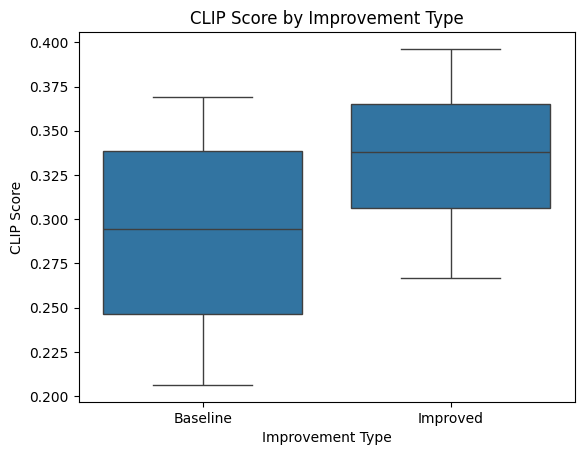

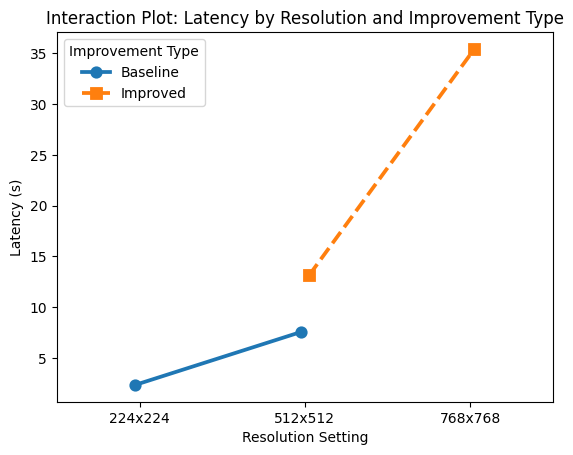

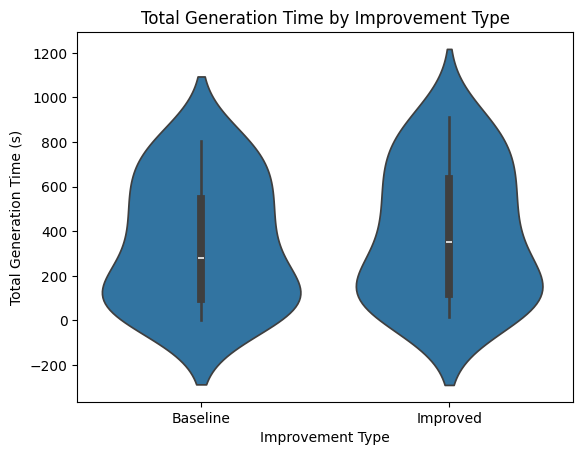

Summary Statistics:
  Improvement_Type    Latency            CLIP_Score           Color_Quality  \
                         mean        std       mean       std          mean   
0         Baseline   5.683929   2.545092   0.290010  0.050113    111.563576   
1         Improved  27.993186  10.708293   0.332818  0.041608    107.747184   

             Total_Gen_Time              
         std           mean         std  
0  16.216883     351.309634  274.726531  
1  14.689888     392.887260  294.548132  


<ipython-input-121-d5e2b59a28a3>:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = data_df.groupby('Improvement_Type').agg({


In [121]:
#ANOVA & STATS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Generate images with specified counts for baseline and improved
data_df = generate_images(baseline_count=15, improved_count=15)

# Check column names to ensure they are correct
print(data_df.columns)
print(data_df.head())

# Strip leading/trailing spaces from column names (if any)
data_df.columns = data_df.columns.str.strip()

# Rename columns to match what is expected in the statistical analysis
data_df = data_df.rename(columns={
    'Latency (s)': 'Latency',
    'Resolution': 'Resolution',
    'Color Quality': 'Color_Quality',
    'Total Gen Time (s)': 'Total_Gen_Time',
    'CLIP Score': 'CLIP_Score'
})

# Ensure categorical columns are treated as categories
data_df['Improvement_Type'] = data_df['Improvement_Type'].astype('category')
data_df['Resolution_Setting'] = data_df['Resolution_Setting'].astype('category')

# Check for missing values
print(data_df.isna().sum())


# One-Way ANOVA for CLIP Score
anova_model = ols('CLIP_Score ~ C(Improvement_Type)', data=data_df).fit()
anova_table = anova_lm(anova_model, typ=2)  # Type-II ANOVA
print("ANOVA Results for CLIP Score:")
print(anova_table)

# Two-Way ANOVA for Latency
anova_model_2way = ols('Latency ~ C(Improvement_Type) + C(Resolution_Setting) + C(Improvement_Type):C(Resolution_Setting)',
                       data=data_df).fit()
anova_table_2way = anova_lm(anova_model_2way, typ=2)  # Type-II ANOVA
print("Two-Way ANOVA Results for Latency:")
print(anova_table_2way)

# Perform Tukey's test for CLIP Score
tukey = pairwise_tukeyhsd(endog=data_df['CLIP_Score'], groups=data_df['Improvement_Type'], alpha=0.05)
print(tukey)

# Box Plot for CLIP Score by Improvement Type
sns.boxplot(x='Improvement_Type', y='CLIP_Score', data=data_df)
plt.title('CLIP Score by Improvement Type')
plt.xlabel('Improvement Type')
plt.ylabel('CLIP Score')
plt.show()

# Interaction plot for Latency
sns.pointplot(x='Resolution_Setting', y='Latency', hue='Improvement_Type', data=data_df, dodge=True, markers=["o", "s"], linestyles=["-", "--"])
plt.title('Interaction Plot: Latency by Resolution and Improvement Type')
plt.xlabel('Resolution Setting')
plt.ylabel('Latency (s)')
plt.legend(title='Improvement Type')
plt.show()

# Violin Plot for Total Generation Time by Improvement Type
sns.violinplot(x='Improvement_Type', y='Total_Gen_Time', data=data_df, inner="box")
plt.title('Total Generation Time by Improvement Type')
plt.xlabel('Improvement Type')
plt.ylabel('Total Generation Time (s)')
plt.show()

# Summary statistics for metrics by Improvement Type
summary_stats = data_df.groupby('Improvement_Type').agg({
    'Latency': ['mean', 'std'],
    'CLIP_Score': ['mean', 'std'],
    'Color_Quality': ['mean', 'std'],
    'Total_Gen_Time': ['mean', 'std']
}).reset_index()

print("Summary Statistics:")
print(summary_stats)